In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import os

import wandb
import torch.nn as nn
import numpy as np
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

from IPython.display import clear_output

import matplotlib.pyplot as plt

In [6]:
from datasets.prot.swissprot import SPSetDataset

from backbones.id import Id
from backbones.fcnet import FCNet

from methods.protonet import ProtoNet
from methods.protoformer import ProtoFormer

  EXISTS: go-basic.obo
go-basic.obo: fmt(1.2) rel(2023-06-11) 46,420 Terms; optional_attrs(relationship)


/home/cat/.local/lib/python3.9/site-packages/numba/core/errors.py:175: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [7]:
%%script false --no-raise-error


! pip install -r requirements.txt

In [8]:
%%script false --no-raise-error


import gdown

url = 'https://drive.google.com/u/0/uc?id=1a3IFmUMUXBH8trx_VWKZEGteRiotOkZS&export=download'

if os.path.exists('swissprot.zip'):
    print('File already downloaded.')
else:
    output = 'swissprot.zip'
    gdown.download(url, output, quiet=False)
    print('Download completed.')

In [9]:
%%script false --no-raise-error


!unzip -q swissprot.zip

!rm -rf swissprot.zip
clear_output()

!mv data/swissprot/go-basic.obo ./

In [10]:
n_way, n_support, n_query, n_train_episode = 5, 5, 15, 5

# Load train dataset. Remember to use make use of functions defined in the `SPSetDataset`.
train_dataset = SPSetDataset(n_way, n_support, n_query, n_episode=n_train_episode, root='./data', mode='train')
train_loader = train_dataset.get_data_loader()

# Load test dataset. Remember to use make use of functions defined in the `SPSetDataset`.
test_dataset = SPSetDataset(n_way, n_support, n_query, n_episode=100, root='./data', mode='test')
test_loader = test_dataset.get_data_loader()


**WARNING: NO VERSION LINE FOUND IN GAF FILE. USING:
!gaf-version: 2.2


ERROR:root:Failed to validate header as GAF v2.2:
[]


HMS:0:00:07.572030 310,057 annotations READ: ./data/swissprot/filtered_goa_uniprot_all_noiea.gaf 
25933 IDs in loaded association branch, BP

**WARNING: NO VERSION LINE FOUND IN GAF FILE. USING:
!gaf-version: 2.2


ERROR:root:Failed to validate header as GAF v2.2:
[]


HMS:0:00:06.879036 310,057 annotations READ: ./data/swissprot/filtered_goa_uniprot_all_noiea.gaf 
25933 IDs in loaded association branch, BP


In [23]:
def train_model(n_way, n_support, n_query, n_train_episode, train_loader, test_loader, backbone):
    wandb.init()
    # Initialize model using the backbone and the optimizer.
    model = ProtoFormer(backbone, n_way, n_support)
    optimizer = torch.optim.Adam(model.parameters(), lr=7e-7)

    test_accs = []; train_accs = []; train_losses = []
    for epoch in range(100):
        model.train()

        epoch_loss = model.train_loop(epoch, train_loader, optimizer)
        train_losses.append(epoch_loss)

        train_acc = model.test_loop(train_loader)
        train_accs.append(train_acc)

        test_acc = model.test_loop(test_loader)
        test_accs.append(test_acc)
        print(f'Epoch {epoch} | Train Loss {epoch_loss} | Train Acc {train_acc} | Test Acc {test_acc}')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 2.5))
    ax1.plot(range(len(train_losses)), train_losses)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Train Loss')
    ax1.grid()

    ax2.plot(range(len(test_accs)), test_accs)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Test Accuracy')
    ax2.grid()
    fig.suptitle(f"n_way={n_way}, n_support={n_support}, n_query={n_query}, n_train_episode={n_train_episode}")

    plt.tight_layout()

loss,▅▇▂▄█▂▅▅▄▃▂▂▃▃▂▃▂▃▄▃▂▁▆▂▄▃▃▄▄▃▄▃▁▂▁▁▃▁▂▃
loss,1.87671


Epoch 0 | Batch 0/5 | Loss 1.047951
5 Test Acc = 56.80% +- 9.19%
100 Test Acc = 51.52% +- 1.87%
Epoch 0 | Train Loss None | Train Acc 56.8 | Test Acc 51.52
Epoch 1 | Batch 0/5 | Loss 4.192494
5 Test Acc = 57.33% +- 6.49%
100 Test Acc = 51.85% +- 1.76%
Epoch 1 | Train Loss None | Train Acc 57.333333333333336 | Test Acc 51.853333333333346
Epoch 2 | Batch 0/5 | Loss 2.333687
5 Test Acc = 57.33% +- 12.12%
100 Test Acc = 53.24% +- 1.85%
Epoch 2 | Train Loss None | Train Acc 57.333333333333336 | Test Acc 53.24
Epoch 3 | Batch 0/5 | Loss 1.604960
5 Test Acc = 67.20% +- 12.05%
100 Test Acc = 53.05% +- 1.81%
Epoch 3 | Train Loss None | Train Acc 67.2 | Test Acc 53.05333333333333
Epoch 4 | Batch 0/5 | Loss 1.134852
5 Test Acc = 70.93% +- 6.54%
100 Test Acc = 52.16% +- 1.99%
Epoch 4 | Train Loss None | Train Acc 70.93333333333332 | Test Acc 52.16
Epoch 5 | Batch 0/5 | Loss 2.169681
5 Test Acc = 63.73% +- 11.15%
100 Test Acc = 54.23% +- 1.56%
Epoch 5 | Train Loss None | Train Acc 63.73333333333333

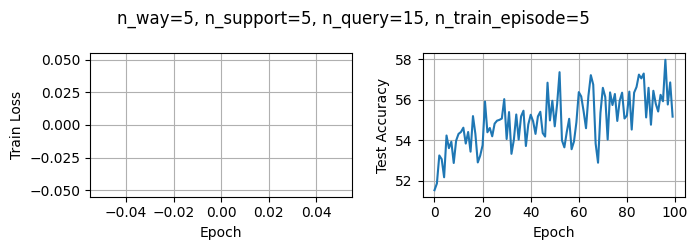

In [24]:
os.environ["WANDB_DISABLED"] = "true"
backbone = Id(train_dataset.x_dim)

train_model(n_way, n_support, n_query, n_train_episode, train_loader, test_loader, backbone)